In [2]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Importing dataset
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet 
2. **ids**: The id of the tweet 
3. **date**: the date of the tweet 
4. **flag**: The query (lyx).
5. **user**: the user that tweeted 
6. **text**: the text of the tweet 

We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

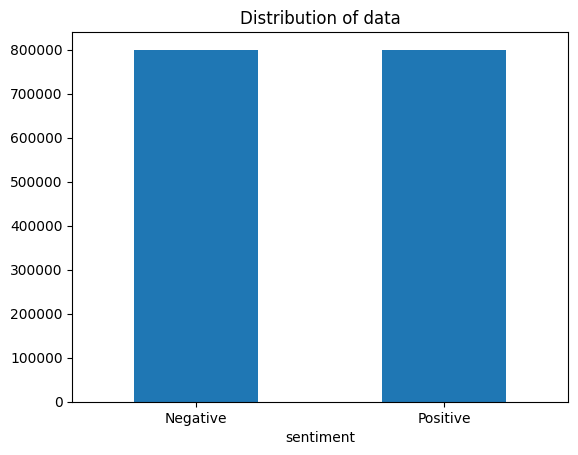

In [3]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../data/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plot the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocessing:

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [5]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 140 seconds


## <a name="p4">Analysing the data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets.

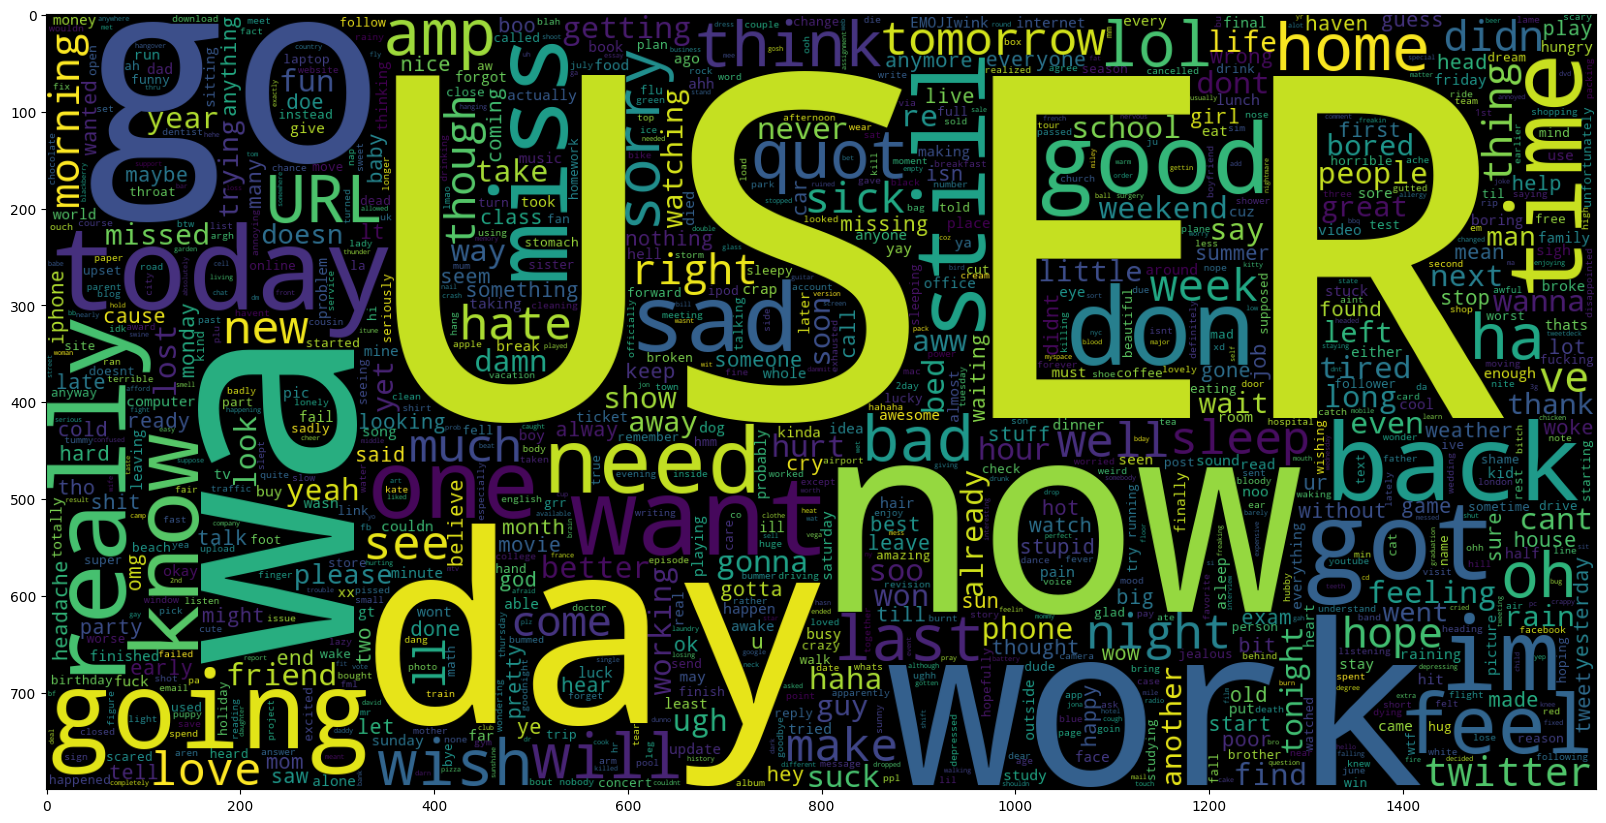

In [8]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

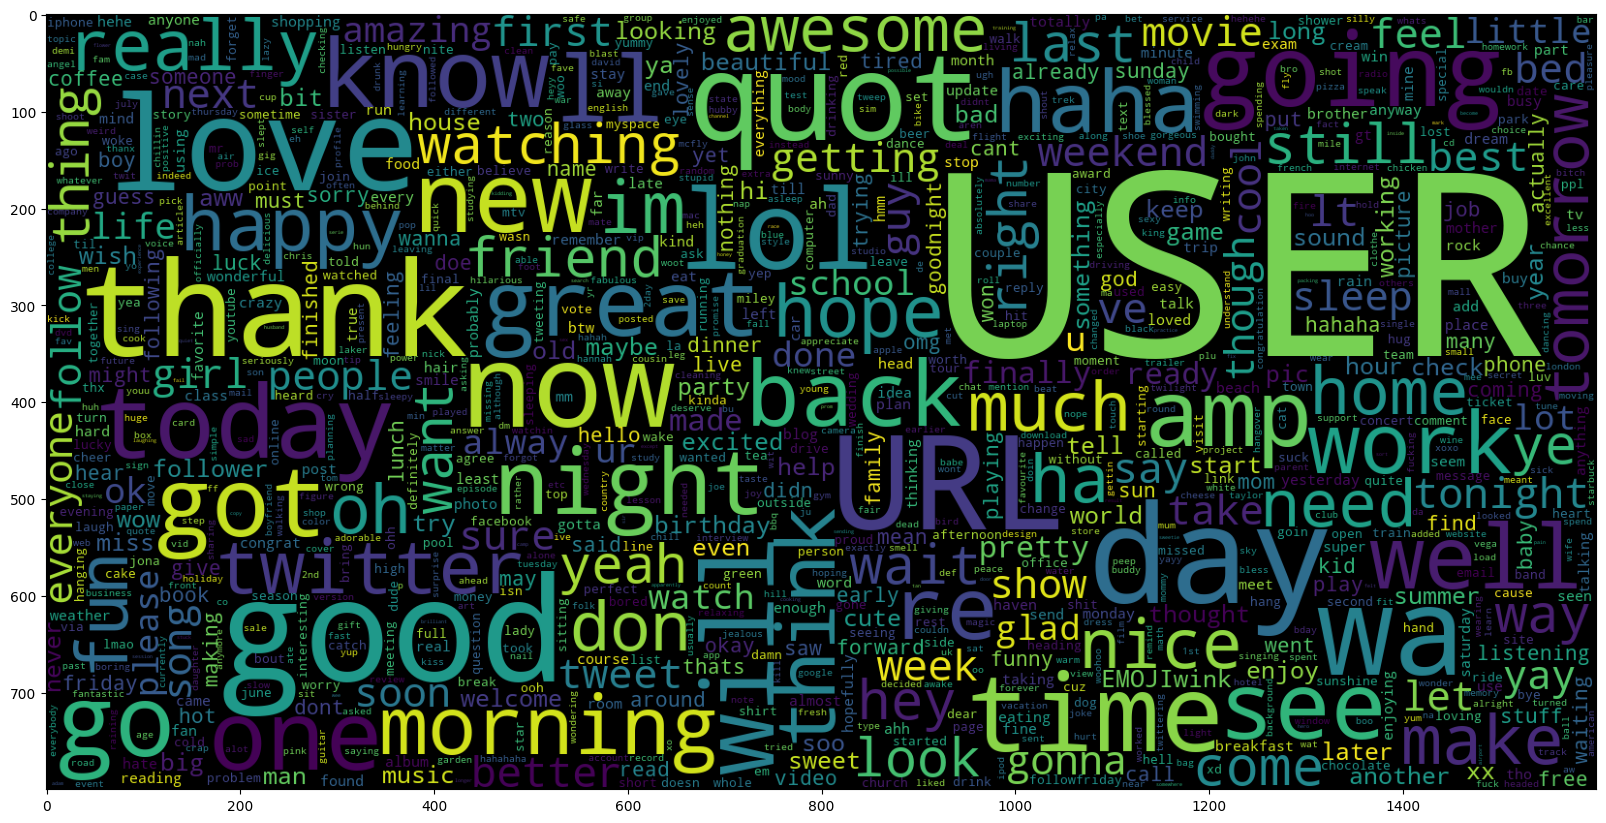

In [9]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting the Data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## TF-IDF Vectoriser

**TF-IDF Vectoriser** converts a collection of raw documents to a matrix of TF-IDF features.

ngram_range:  is the range of number of words in a sequence.

max_features: specifies the number of features to consider.

In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))


Vectoriser fitted.
No. of feature_words:  500000


### <a name="p7">Tranforming the dataset</a>
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**.

In [12]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## Creating and Evaluating Models

We will create 3 different types of model: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

Since our dataset has equal number of positive and negative Predictions. We're choosing **Accuracy** as our evaluation metric. 

### Evaluate Model Function

In [13]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



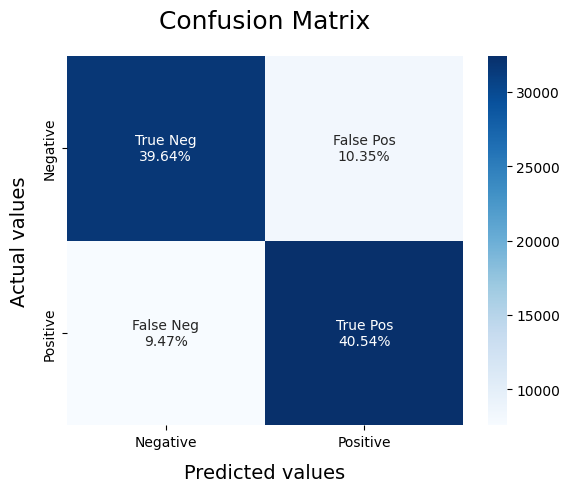

In [14]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



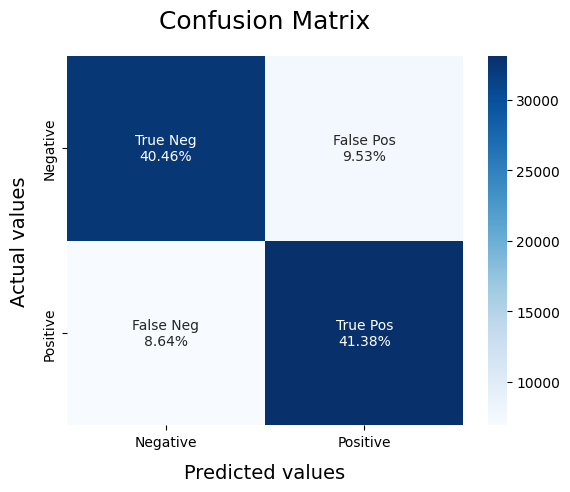

In [15]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



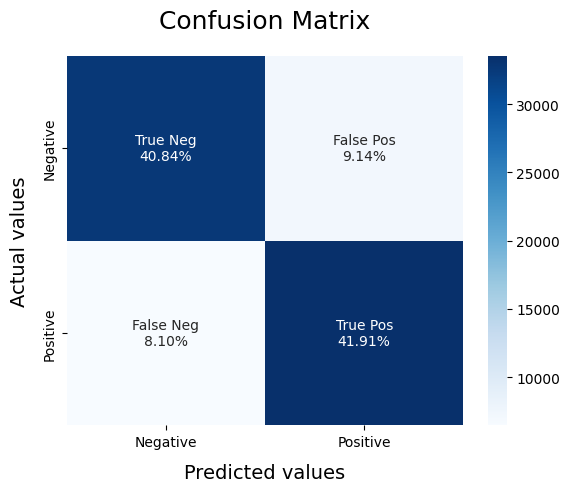

In [16]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

We can clearly see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves nearly **82% accuracy** while classifying the sentiment of a tweet.

Although it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on. It also achieves **80% accuracy** while calssifying.

## Saving the Models
We're using **joblib** to save **Vectoriser and Logistic Regression Model** for futher use.

In [17]:
from joblib import dump
dump(vectoriser, 'vectoriser.joblib')  # TF-IDF vector saving
dump(LRmodel, 'sentiment_LR.joblib')  # Saving the ML model

['sentiment_LR.joblib']

In [18]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow")

import os

os.environ["MLFLOW_TRACKING_USERNAME"] = "mbialeuk"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "8f2d12abf93dce76501907dfd2f4f03dd7232c47"



In [19]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to évaluate and log the model
def model_evaluate_and_log(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Log metrics and model
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Model log 
        mlflow.sklearn.log_model(model, model_name)

# 1. BernoulliNB
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_evaluate_and_log(BNBmodel, X_test, y_test, "BernoulliNB")

# 2. LinearSVC
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate_and_log(SVCmodel, X_test, y_test, "LinearSVC")

# 3. LogisticRegression
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate_and_log(LRmodel, X_test, y_test, "LogisticRegression")

# Lancer le serveur MLFlow localement (à exécuter dans une autre console)
# mlflow ui
# Accédez à http://127.0.0.1:5000 pour voir les runs et les modèles enregistrés.


BernoulliNB Metrics:
Accuracy: 0.8018
Precision: 0.8018925558530413
Recall: 0.8018
F1 Score: 0.801784170444347


2025/01/27 21:56:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BernoulliNB at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0/runs/f08eec7b81764e30a9b63b7f04567513
🧪 View experiment at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0
LinearSVC Metrics:
Accuracy: 0.8183375
Precision: 0.8184377879413012
Recall: 0.8183375
F1 Score: 0.8183226235659282


2025/01/27 21:58:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearSVC at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0/runs/d74d392a42854704ad36db2255b47836
🧪 View experiment at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0
LogisticRegression Metrics:
Accuracy: 0.8275375
Precision: 0.8276793029725195
Recall: 0.8275375
F1 Score: 0.8275182144582915


2025/01/27 21:59:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0/runs/6e995bb575d343dd91a77d56d70c35fe
🧪 View experiment at: https://dagshub.com/mbialeuk/tweet-sentiments-analysis.mlflow/#/experiments/0


## Using the Model.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.

In [20]:
import os
def load_models():
    
    # Load the vectoriser and the LR Model.
    current_dir = os.path.dirname(os.path.abspath(__file__))
    vectoriser = load(os.path.join(current_dir, 'vectoriser.joblib'))
    LRmodel = load(os.path.join(current_dir, 'sentiment_LR.joblib'))
    
    return vectoriser, LRmodel


def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "I'm starting to like this movie...",
            "I'm sorry Christoper Nolan, but this movie is a complete disaster",
            "messi is the best football player in the world",
            "real madrid is the worst team in the world"]
    
    
    df = predict(vectoriser, LRmodel, text)
    print(df)

                                                text sentiment
0                                     I hate twitter  Negative
1                         May the Force be with you.  Positive
2                    Mr. Stark, I don't feel so good  Negative
3                 I'm starting to like this movie...  Positive
4  I'm sorry Christoper Nolan, but this movie is ...  Negative
5     messi is the best football player in the world  Positive
6         real madrid is the worst team in the world  Negative
